In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.ticker import LinearLocator

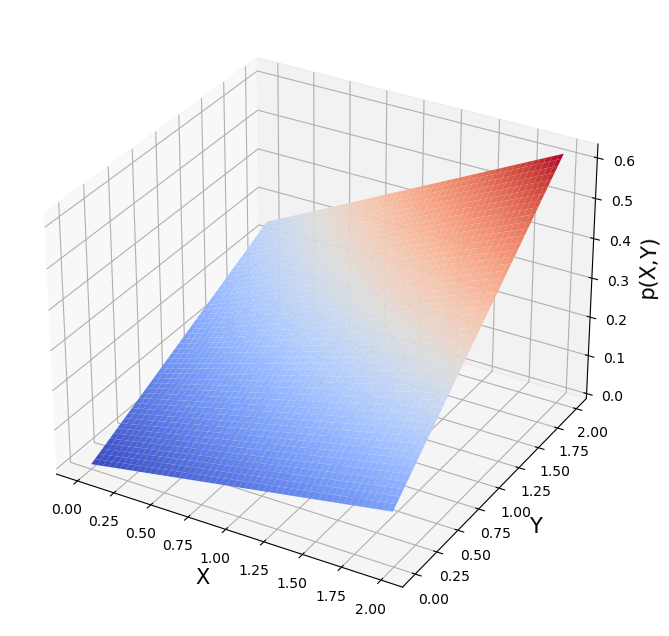

<Figure size 1000x1500 with 0 Axes>

In [2]:
# Target bivariate distribution
x, y = np.arange(0, 2, 0.01), np.arange(0, 2, 0.01)
X, Y = np.meshgrid(x, y)
fxy = (2*X + 4*Y + 2*X*Y)/32
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize = (12, 8))
plt.figure(figsize = (10, 15))
ax.plot_surface(X, Y, fxy, cmap = cm.coolwarm)
ax.set_xlabel('X', fontsize = 15)
ax.set_ylabel('Y', fontsize = 15)
ax.set_zlabel('p(X,Y)', fontsize = 15)
plt.show()

# 1) Gibbs Sampling Based On The Inverse Transform

In [3]:
T = 2000
x, y = np.zeros((T, 1)), np.zeros((T, 1))

# initial values of each component in the target distribution
x[0] = 2.3   # arbitrary chosen
y[0] = -0.3  # arbitrary chosen

# repeat the loop according to chain length
for t in range(1, T):
    # for component x:
    u = np.random.uniform(0, 1)
    x[t] = 2*( np.sqrt( u*( 3*y[t-1]**2 + 4*y[t-1] + 1 ) + y[t-1]**2 ) - y[t-1] ) / (y[t-1] + 1)

    # for component y:
    u = np.random.uniform(0, 1)
    y[t] = ( np.sqrt( 8*u*( x[t]**2 + 3*x[t] + 2) + x[t]**2 ) - x[t] ) / (x[t] + 2)

print('Mean of x = ', np.mean(x))
print('Mean of y = ', np.mean(y))

Mean of x =  1.1515544878595338
Mean of y =  1.2449896951988058


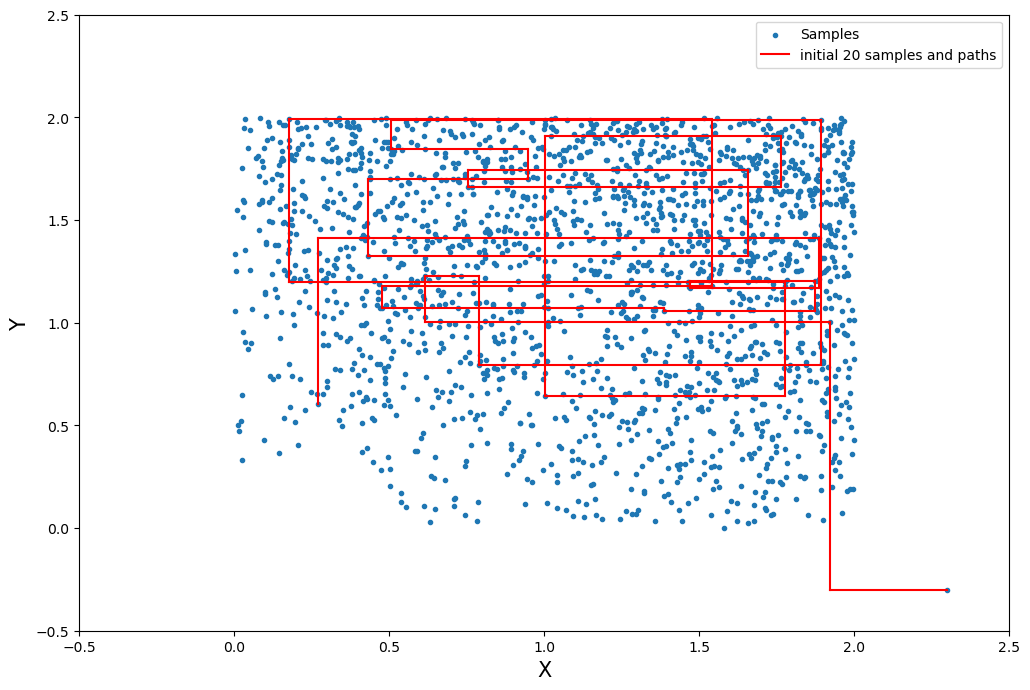

In [4]:
plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = '.')
for t in range(20):
    plt.plot([x[t], x[t+1]], [y[t], y[t]], 'r-')
    plt.plot([x[t+1], x[t+1]], [y[t], y[t+1]], 'r-')

plt.legend(['Samples', 'initial 20 samples and paths'])
plt.xlabel('X', fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.xlim([-0.5, 2.5])
plt.ylim([-0.5, 2.5])
plt.show()

In [5]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker='.')
    ax.set_xlim((0,2))
    ax.set_ylim((0,2))
    ax.set_xlabel('X', fontsize = 15)
    ax.set_ylabel('Y', fontsize = 15)

    # now determine nice limits by hand:
    binwidth = 0.10
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, density = True)
    ax_histy.hist(y, bins=bins, orientation='horizontal', density = True)

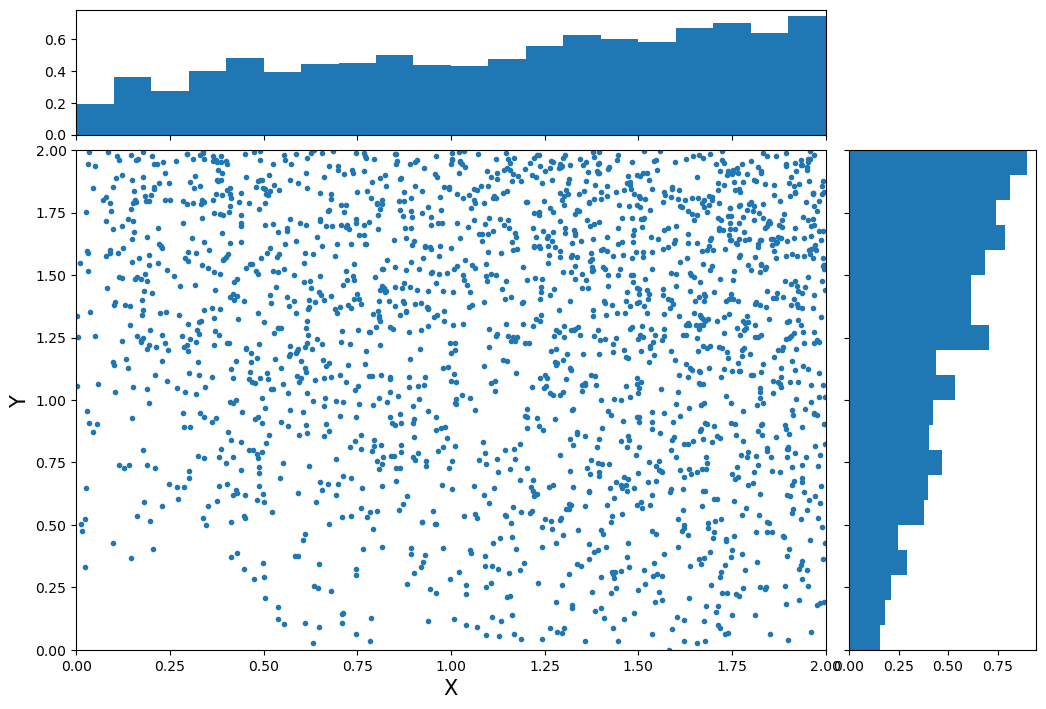

In [6]:
fig = plt.figure(figsize = (12, 8))
gs = fig.add_gridspec(2, 2, width_ratios = (4, 1), height_ratios = (1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals
scatter_hist(x, y, ax, ax_histx, ax_histy)

Text(0, 0.5, 'F(y|x)')

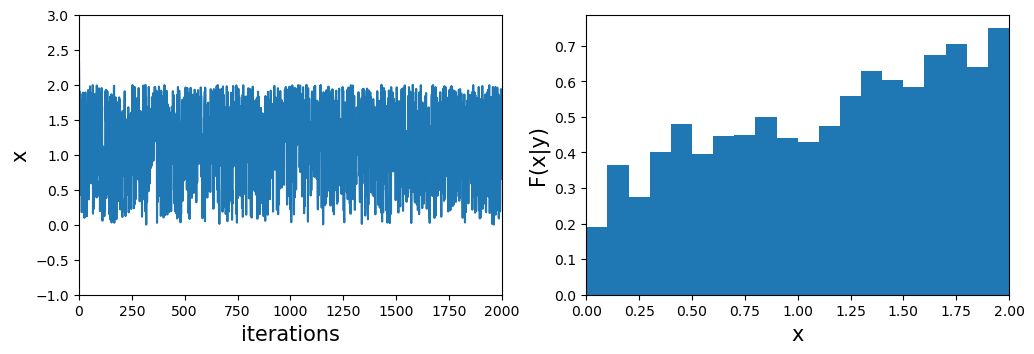

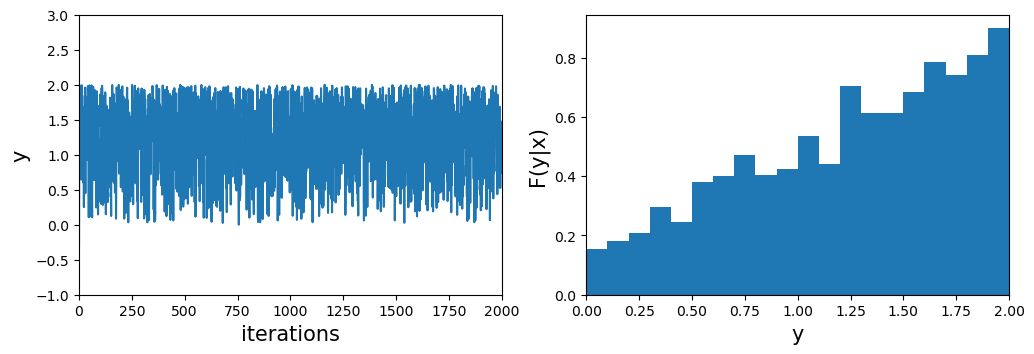

In [7]:
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(np.arange(T), x)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.xlim((0, 2000))
plt.ylim((-1, 3))

plt.subplot(222)
binwidth = 0.10
xmax = np.max(np.abs(x))
lim = (int(xmax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)
plt.hist(x, bins=bins, density = True)
plt.xlim((0, 2))
plt.xlabel('x', fontsize=15)
plt.ylabel('F(x|y)', fontsize=15)

plt.figure(figsize = (12, 8))
plt.subplot(223)
plt.plot(np.arange(T), y)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xlim((0, 2000))
plt.ylim((-1, 3))

plt.subplot(224)
binwidth = 0.10
ymax = np.max(np.abs(y))
lim = (int(ymax/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)
plt.hist(y, bins=bins, density = True)
plt.xlim((0, 2))
plt.xlabel('y', fontsize=15)
plt.ylabel('F(y|x)', fontsize=15)

# 2) Gibbs Sampling BAsed On The Rejection Sampling

In [8]:
T = 2000

# define the bi-variate target distribution
def p(x, y):
    return (2*x + 4*y + 2*x*y)

# define the proposal distribution
valMin, valMax = 0, 2
def q(x, ValMin, valMax):
    if (x >= valMin) & (x <= valMax):
        return 1.0 / (valMax - valMin)
    else:
        return 0

c = 41

x, y = np.zeros((T, 1)), np.zeros((T, 1))
x[0], y[0] = -0.3, -0.3

for t in range(1, T):
    # sample from x|y
    while 1:
        xStar = np.random.uniform(0, 2)
        ratioX = p(xStar, y[t-1]) / (c * q(xStar, valMin, valMax))
        u = np.random.uniform(0, 1)
        if u < ratioX:
            x[t] = xStar
            break

    # sample from y|x
    while 1:
        yStar = np.random.uniform(0, 2)
        ratioY = p(x[t], yStar) / (c * q(yStar, valMin, valMax))
        u = np.random.uniform(0, 1)
        if u < ratioY:
            y[t] = yStar
            break

print('Mean of x = ', np.mean(x))
print('Mean of y = ', np.mean(y))

Mean of x =  1.163195704340502
Mean of y =  1.2654897832918715


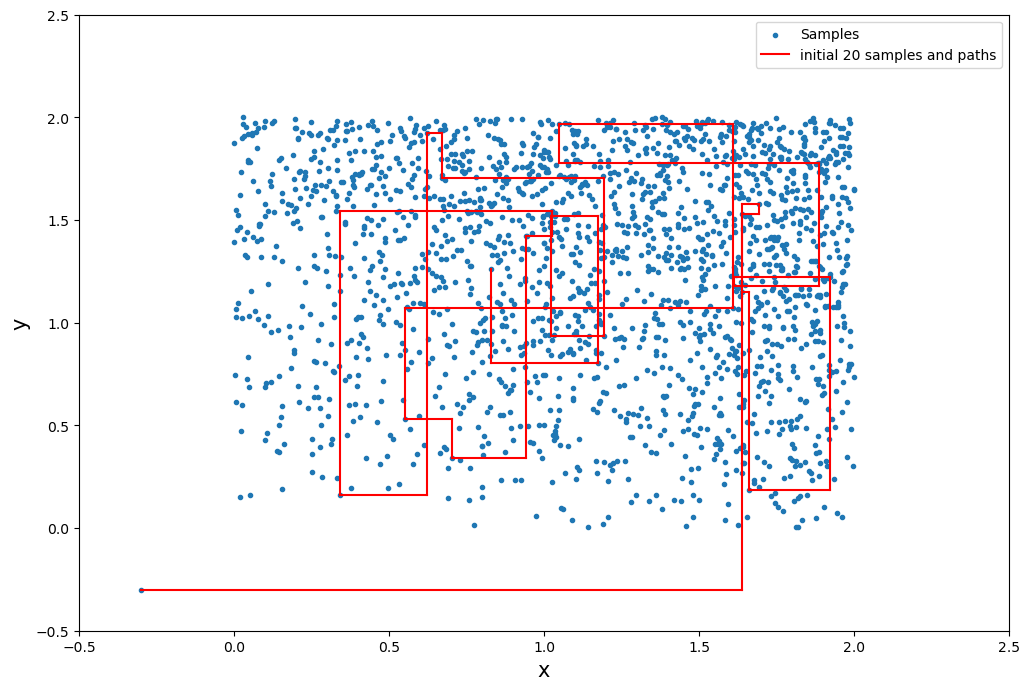

In [9]:
plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = '.')
for t in range(20):
    plt.plot([x[t], x[t+1]], [y[t], y[t]], 'r-')
    plt.plot([x[t+1], x[t+1]], [y[t], y[t+1]], 'r-')

plt.legend(['Samples', 'initial 20 samples and paths'])
plt.xlabel('x', fontsize = 15)
plt.ylabel('y', fontsize = 15)
plt.xlim([-0.5, 2.5])
plt.ylim([-0.5, 2.5])
plt.show()

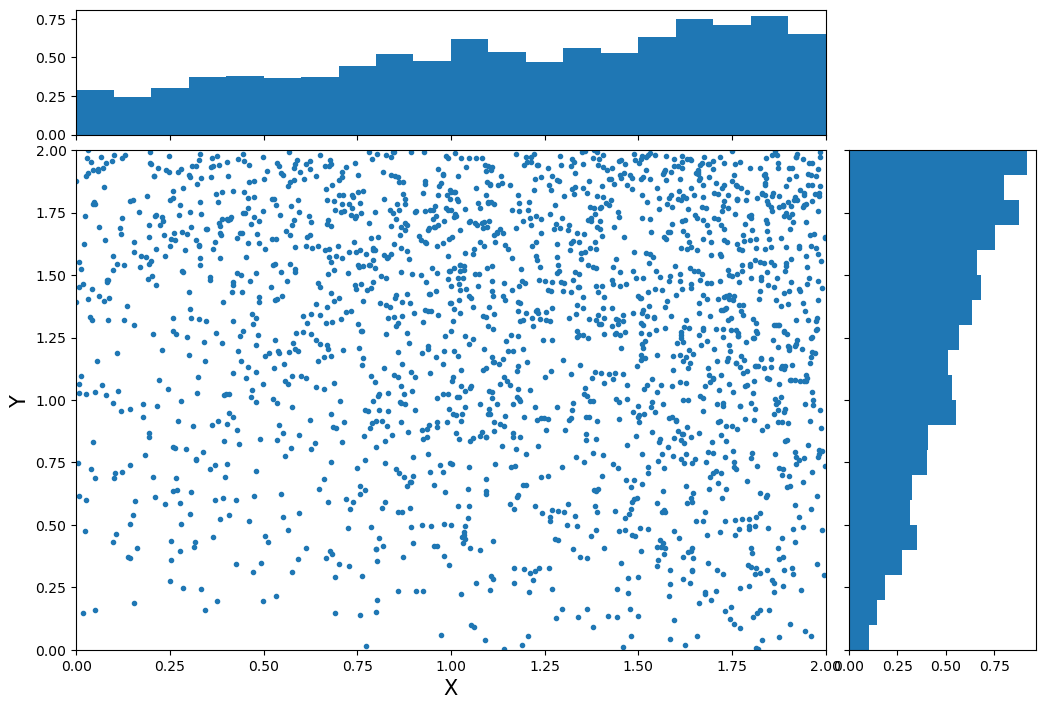

In [10]:
fig = plt.figure(figsize = (12, 8))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left = 0.1, right = 0.9, bottom = 0.1, top = 0.9,
                      wspace = 0.05, hspace = 0.05)

# Create the Axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals
scatter_hist(x, y, ax, ax_histx, ax_histy)

# 3) Gibbs Sampling for Poisson-Gamma Bayesian Model

In [11]:
T = 5000

# pump failure data
n = 10   # the number of observed pumps
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22])   # the number of failures at each pump
time = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.048, 1.048, 2.096, 10.48])   # observed time (not RV)

beta = np.zeros((T, 1))
lambda_ = np.zeros((T, n))

# hyperparameters of Gamma prior (a, b)
a = 1.802
beta[0] = 0.01

# intialization of the failure rate
lambda_[0, :] = np.random.gamma(0.25 * (y+a), 0.25 * (time + 1/beta[0])**(-1))

# hyperparameters of Gamma prior (hGamma, hDelta)
hGamma = 0.01
hDelta = 1

# repeat the loop according to chain length
for t in range(1, T):
    lambda_[t, :] = np.random.gamma(y+a, (time + 1/beta[t-1])**(-1))
    beta[t] = np.random.gamma(hGamma + n*a, (1/hDelta + sum(lambda_[t, :]))**(-1))

In [12]:
np.mean(beta), np.std(beta)

(1.756871784574436, 0.5531383706183356)

In [13]:
np.mean(lambda_, axis = 0), np.std(lambda_, axis = 0)

(array([0.07107385, 0.17356548, 0.10648255, 0.12521647, 0.81564363,
        0.65061209, 1.70311987, 1.71649696, 2.13533726, 2.15378133]),
 array([0.02711542, 0.10289952, 0.04091466, 0.03184269, 0.38019391,
        0.14354227, 1.06679787, 1.03614987, 0.9139507 , 0.4460363 ]))

(0.0, 0.4)

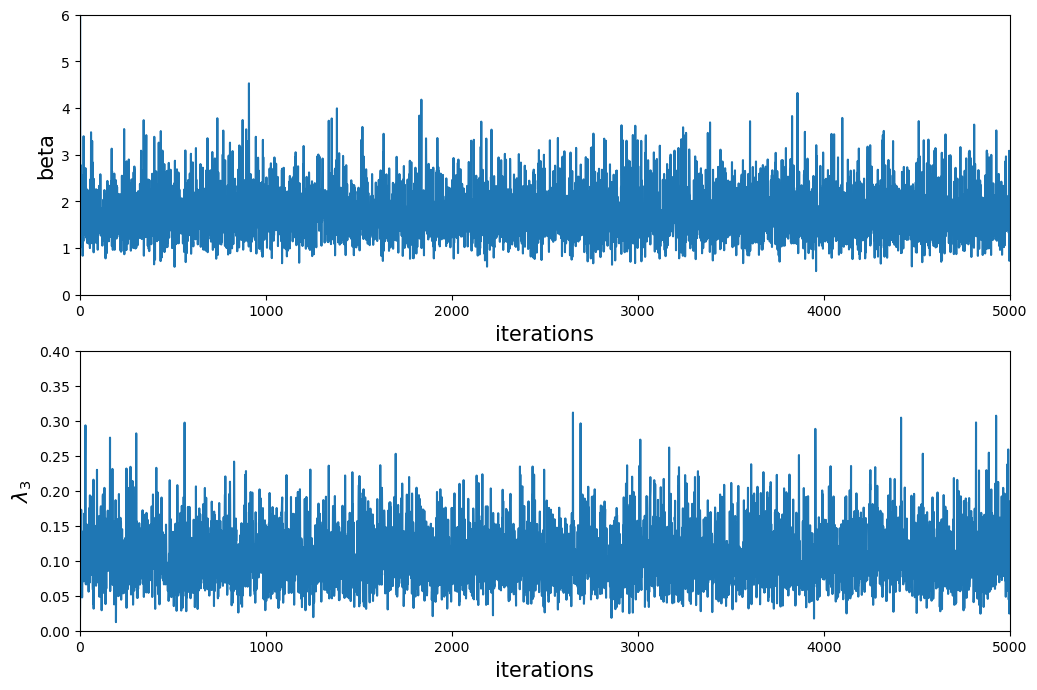

In [14]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(np.arange(T), beta)
plt.xlabel('iterations', fontsize=15)
plt.ylabel('beta', fontsize=15)
plt.xlim((0, T))
plt.ylim((0, 6))

plt.subplot(212)
plt.plot(np.arange(T), lambda_[:, 2])
plt.xlabel('iterations', fontsize=15)
plt.ylabel(r'$\lambda_3$', fontsize=15)
plt.xlim((0, T))
plt.ylim((0, 0.4))

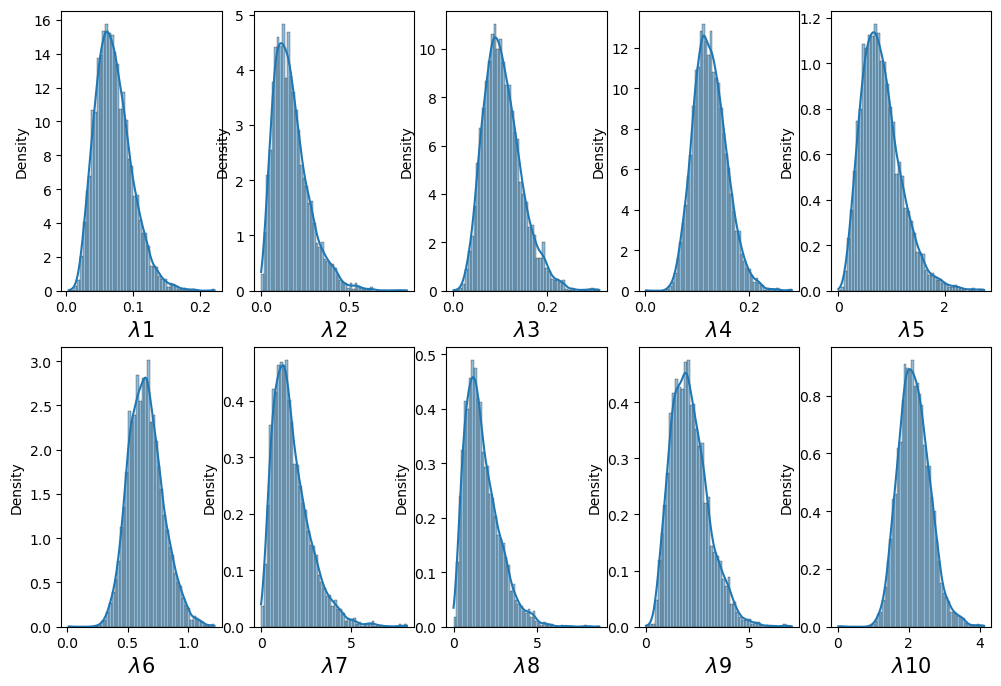

In [15]:
plt.figure(figsize = (12, 8))
for iTemp in range(10):
    plt.subplot(2, 5, iTemp+1)
    Vecpoints = np.linspace(np.min(lambda_[:, iTemp]), np.max(lambda_[:, iTemp]), 1000)[:, None]
    sns.histplot(data = lambda_[:, iTemp], stat='density', kde=True)
    plt.xlabel(r'$\lambda$' + str(iTemp+1), fontsize=15)